In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
import torch

from transformers import BertTokenizer, BertModel
from tqdm import tqdm
from time import time
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

### Extraction Features

In [2]:
df = pd.read_csv("../PreProcessing/processed_data/Resume_proc_lemm.csv")

In [3]:
# Conversione in un formato utile a BERT
resumes = df["Resume_str"].tolist()
labels = df["Category"].astype("category").cat.codes

In [4]:
X_train, X_test, y_train, y_test = train_test_split(resumes, labels, test_size=0.2, random_state=42)

In [5]:
# Caricamento tokenizer e modello BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")
bert_model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [6]:
# Funzione per ottenere l'embedding del CLS token
def get_bert_embedding(text):
    with torch.no_grad():
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
        outputs = bert_model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
    return cls_embedding

In [7]:
X_train_embed = np.array([get_bert_embedding(text) for text in tqdm(X_train)])
X_test_embed = np.array([get_bert_embedding(text) for text in tqdm(X_test)])

100%|██████████| 497/497 [04:06<00:00,  2.02it/s]


In [8]:
def smote(X_train, y_train):
    #print("Distribuzione delle classi nel training set prima di SMOTE:")
    # print(y_train.value_counts())
    
    # Identifica le classi minoritarie
    class_counts = y_train.value_counts()
    min_classes = class_counts[class_counts < 0.7*class_counts.mean()].index.tolist()
    
    print(f"Applicazione di SMOTE alle classi: {min_classes} \n")
    
    # Crea un dizionario per la strategia di campionamento
    target_size = int(class_counts.max() * 0.8)
    sampling_strategy = {cls: target_size for cls in min_classes}
    
    # Applica SMOTE
    smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    # print("Distribuzione delle classi nel training set dopo SMOTE:")
    # print(pd.Series(y_train_resampled).value_counts())
    
    return X_train_resampled, y_train_resampled

In [9]:
X_train_resampled, y_train_resampled = smote(X_train_embed, y_train.reset_index(drop=True))

Applicazione di SMOTE alle classi: [2, 5, 8] 



### Support Vector Classifier

In [10]:
def report(results, n_top=10):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print(f"Model with rank: {i}")
            print(f"Mean validation score: {results['mean_test_score'][candidate]:.3f} (std: {results['std_test_score'][candidate]:.3f})")
            print(f"Parameters: {results['params'][candidate]}")
            print("")

In [11]:
skf = StratifiedKFold(n_splits=5)

In [12]:
# Pipeline: TF-IDF + Scaling + SVM
svm_pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),  # with_mean=False per sparse matrix
    ('clf', SVC())
])

param_grid_svm = [
    {
        'clf__kernel': ['linear'],
        'clf__C': [0.1, 1, 10, 100]
    },
    {
        'clf__kernel': ['poly'],
        'clf__C': [1, 10],
        'clf__degree': [2, 3],
        'clf__coef0': [0.5, 1.0]
    }
]

grid_svm = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=param_grid_svm,
    cv=skf,
    scoring='accuracy',
    verbose=3,
    n_jobs=-1
)


In [13]:
#'''
start = time()
grid_search_svm = grid_svm.fit(X_train_resampled, y_train_resampled)
print(f"GridSearchCV took {(time() - start):.2f} seconds for {len(grid_search_svm.cv_results_['params'])} candidates parameter settings.\n")

report(grid_search_svm.cv_results_)
print(grid_search_svm.best_params_)
#'''

Fitting 5 folds for each of 12 candidates, totalling 60 fits
GridSearchCV took 26.38 seconds for 12 candidates parameter settings.

Model with rank: 1
Mean validation score: 0.524 (std: 0.028)
Parameters: {'clf__C': 1, 'clf__coef0': 1.0, 'clf__degree': 3, 'clf__kernel': 'poly'}

Model with rank: 2
Mean validation score: 0.517 (std: 0.032)
Parameters: {'clf__C': 10, 'clf__coef0': 0.5, 'clf__degree': 2, 'clf__kernel': 'poly'}

Model with rank: 3
Mean validation score: 0.510 (std: 0.023)
Parameters: {'clf__C': 10, 'clf__coef0': 0.5, 'clf__degree': 3, 'clf__kernel': 'poly'}

Model with rank: 4
Mean validation score: 0.509 (std: 0.028)
Parameters: {'clf__C': 10, 'clf__coef0': 1.0, 'clf__degree': 2, 'clf__kernel': 'poly'}

Model with rank: 5
Mean validation score: 0.509 (std: 0.021)
Parameters: {'clf__C': 10, 'clf__coef0': 1.0, 'clf__degree': 3, 'clf__kernel': 'poly'}

Model with rank: 6
Mean validation score: 0.508 (std: 0.021)
Parameters: {'clf__C': 1, 'clf__coef0': 0.5, 'clf__degree': 3, 

In [14]:
print(grid_search_svm.best_params_)

{'clf__C': 1, 'clf__coef0': 1.0, 'clf__degree': 3, 'clf__kernel': 'poly'}


In [15]:
'''
results = pd.DataFrame(grid_search_svm.cv_results_)

filtered = results[
    (results['param_criterion'] == 'gini') & 
    (results['param_max_features'] == 'sqrt')
]

pvt = filtered.pivot_table(
    values='mean_test_score',
    index='param_max_depth',
    columns='param_n_estimators'
)

f, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(pvt, cmap='viridis', annot=True, ax=ax)
plt.title('Accuracy Score (criterion=gini, max_features=sqrt)')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.show()
'''

"\nresults = pd.DataFrame(grid_search_svm.cv_results_)\n\nfiltered = results[\n    (results['param_criterion'] == 'gini') & \n    (results['param_max_features'] == 'sqrt')\n]\n\npvt = filtered.pivot_table(\n    values='mean_test_score',\n    index='param_max_depth',\n    columns='param_n_estimators'\n)\n\nf, ax = plt.subplots(figsize=(6, 5))\nsns.heatmap(pvt, cmap='viridis', annot=True, ax=ax)\nplt.title('Accuracy Score (criterion=gini, max_features=sqrt)')\nplt.xlabel('n_estimators')\nplt.ylabel('max_depth')\nplt.show()\n"

In [16]:
SVC_Model_best = grid_search_svm.best_estimator_
prediction = SVC_Model_best.predict(X_test_embed)

In [17]:
# SVC_Model_best = RandomForestClassifier(random_state=42, max_features='sqrt', n_estimators= 700, max_depth=10, criterion='gini')
# SVC_Model_best.fit(X_train_resampled, y_train_resampled)

In [18]:
# prediction = SVC_Model_best.predict(X_test_features)

In [19]:
print("Training Score: {:.2f}".format(SVC_Model_best.score(X_train_resampled, y_train_resampled)))
print("Test Score: {:.2f}".format(SVC_Model_best.score(X_test_embed, y_test)))

Training Score: 0.79
Test Score: 0.54


In [20]:

print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.71      0.79      0.75        28
           1       0.62      0.27      0.37        30
           2       0.18      0.20      0.19        10
           3       0.45      0.64      0.53        14
           4       0.47      0.39      0.42        18
           5       0.00      0.00      0.00         5
           6       0.74      0.71      0.72        24
           7       0.50      0.75      0.60        16
           8       0.00      0.00      0.00         3
           9       0.59      0.43      0.50        23
          10       0.77      0.77      0.77        31
          11       0.82      0.72      0.77        32
          12       0.30      0.13      0.18        23
          13       0.64      0.47      0.55        19
          14       0.48      0.55      0.51        22
          15       0.45      0.71      0.56        14
          16       0.50      0.48      0.49        25
          17       0.46    

<Figure size 1500x1000 with 0 Axes>

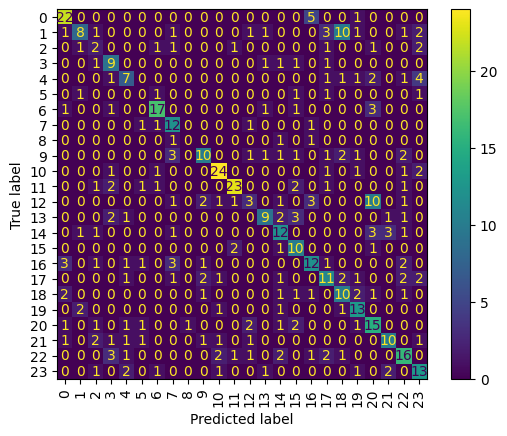

In [21]:
plt.figure(figsize=(15, 10))  # Imposta la dimensione della figura
ConfusionMatrixDisplay.from_predictions(y_test, prediction)
plt.xticks(rotation=90)
plt.show()